# Model Training - Aircraft Threat Detection (Google Colab)

Train YOLOv8n with GPU acceleration:
1. **Baseline** - No augmentation
2. **Augmented** - With on-the-fly augmentation

Results automatically saved to Google Drive.

## Step 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
print('Drive mounted successfully!')

Mounted at /content/drive
Drive mounted successfully!


## Step 2: Check GPU

In [2]:
import torch
print(f'GPU Available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU Device: {torch.cuda.get_device_name(0)}')
else:
    print('WARNING: No GPU! Enable it: Runtime -> Change runtime type -> GPU')

GPU Available: True
GPU Device: NVIDIA A100-SXM4-40GB


## Step 3: Install Packages

In [3]:
!pip install ultralytics -q
print('Packages installed!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00
Packages installed!


## Step 4: Extract Dataset

In [4]:
# Extract dataset from Drive to Colab local storage (faster training)
zip_path = '/content/drive/MyDrive/521_final_project/yolo_dataset.zip'

print('Extracting dataset to /content/ for faster access...')
print('This may take 5-10 minutes...')

!unzip -q {zip_path} -d /content/

# Verify
!ls /content/data/processed/yolo_format/
print('Dataset extracted to /content/data/processed/yolo_format/')

Extracting dataset to /content/ for faster access...
This may take 5-10 minutes...
classes.txt  class_mapping.json  dataset.yaml  images  labels
Dataset extracted to /content/data/processed/yolo_format/


## Step 5: Configuration

In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import yaml
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'model': 'yolov8n.pt',
    'epochs': 50,
    'batch_size': 16,
    'img_size': 640,
    'patience': 10,
    'device': 0,
}

# Paths - Data from /content/, Results to Drive
YOLO_DIR = Path('/content/data/processed/yolo_format')
DATASET_YAML = YOLO_DIR / 'dataset.yaml'

# Save results to Drive (will persist after Colab disconnects)
DRIVE_PROJECT = Path('/content/drive/MyDrive/521_final_project')
RESULTS_DIR = DRIVE_PROJECT / 'results/models_output'
VIZ_DIR = DRIVE_PROJECT / 'results/visualizations/training'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print('Configuration:')
print(f'  Model: {CONFIG["model"]}')
print(f'  Epochs: {CONFIG["epochs"]}')
print(f'  Dataset: {DATASET_YAML}')
print(f'  Results save to Drive: {RESULTS_DIR}')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Configuration:
  Model: yolov8n.pt
  Epochs: 50
  Dataset: /content/data/processed/yolo_format/dataset.yaml
  Results save to Drive: /content/drive/MyDrive/521_final_project/results/models_output


## Step 6: Verify Dataset

In [6]:
with open(DATASET_YAML, 'r') as f:
    dataset_config = yaml.safe_load(f)

train_count = len(list((YOLO_DIR / 'images/train').glob('*.jpg')))
val_count = len(list((YOLO_DIR / 'images/val').glob('*.jpg')))

print('Dataset:')
print(f'  Classes: {dataset_config["nc"]}')
print(f'  Train: {train_count:,}')
print(f'  Val: {val_count:,}')

Dataset:
  Classes: 195
  Train: 32,979
  Val: 10,522


## Step 7: Train Baseline (No Augmentation)

In [10]:
print('='*60)
print('TRAINING BASELINE MODEL (NO AUGMENTATION)')
print('='*60)

model_baseline = YOLO(CONFIG['model'])

results_baseline = model_baseline.train(
    data=str(DATASET_YAML),
    epochs=CONFIG['epochs'],
    imgsz=CONFIG['img_size'],
    batch=CONFIG['batch_size'],
    device=CONFIG['device'],
    patience=CONFIG['patience'],
    project=str(RESULTS_DIR),
    name='baseline_no_aug',
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    degrees=0.0, translate=0.0, scale=0.0,
    fliplr=0.0, mosaic=0.0,
    save=True, plots=True
)

print('Baseline complete!')

TRAINING BASELINE MODEL (NO AUGMENTATION)
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/processed/yolo_format/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=baseline_no_aug5, nbs=64, nms=False, opset=None, optimize=False, opt

## Step 7: Update Dataset YAML Paths

In [9]:
import yaml
from pathlib import Path

# Define the correct base path in Colab
colab_data_path = Path('/content/data/processed/yolo_format')

# Load the dataset.yaml file
with open(DATASET_YAML, 'r') as f:
    dataset_config = yaml.safe_load(f)

# Update the 'path', 'train', 'val', and 'test' keys to point to the Colab paths
dataset_config['path'] = str(colab_data_path)
dataset_config['train'] = 'images/train'
dataset_config['val'] = 'images/val'
# Check if 'test' key exists before updating
if 'test' in dataset_config and dataset_config['test']:
    dataset_config['test'] = 'images/test'

# Save the updated dataset.yaml file
with open(DATASET_YAML, 'w') as f:
    yaml.safe_dump(dataset_config, f)

print(f'Updated dataset.yaml at {DATASET_YAML} with Colab paths:')
with open(DATASET_YAML, 'r') as f:
    print(f.read())

Updated dataset.yaml at /content/data/processed/yolo_format/dataset.yaml with Colab paths:
names:
- 707-320
- 727-200
- 737-200
- 737-300
- 737-400
- 737-500
- 737-600
- 737-700
- 737-800
- 737-900
- 747-100
- 747-200
- 747-300
- 747-400
- 757-200
- 757-300
- 767-200
- 767-300
- 767-400
- 777-200
- 777-300
- A10
- A300B4
- A310
- A318
- A319
- A320
- A321
- A330-200
- A330-300
- A340-200
- A340-300
- A340-500
- A340-600
- A380
- A400M
- AG600
- AH64
- AKINCI
- ATR-42
- ATR-72
- AV8B
- An-12
- An124
- An22
- An225
- An72
- B1
- B2
- B21
- B52
- BAE 146-200
- BAE 146-300
- BAE-125
- Be200
- Beechcraft 1900
- Boeing 717
- C-130
- C-47
- C1
- C130
- C17
- C2
- C390
- C5
- CH47
- CH53
- CL415
- CRJ-200
- CRJ-700
- CRJ-900
- Cessna 172
- Cessna 208
- Cessna 525
- Cessna 560
- Challenger 600
- DC-10
- DC-3
- DC-6
- DC-8
- DC-9-30
- DH-82
- DHC-1
- DHC-6
- DHC-8-100
- DHC-8-300
- DR-400
- Dornier 328
- E-170
- E-190
- E-195
- E2
- E7
- EF2000
- EMB-120
- EMB314
- ERJ 135
- ERJ 145
- Embraer Le

## Step 8: Train Baseline (No Augmentation)

In [11]:
metrics_baseline = model_baseline.val()
print('Baseline Performance:')
print(f'mAP@0.5: {metrics_baseline.box.map50:.4f}')
print(f'mAP@0.5:0.95: {metrics_baseline.box.map:.4f}')

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,369,509 parameters, 0 gradients, 9.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3574.6±1025.3 MB/s, size: 861.5 KB)
val: Scanning /content/data/processed/yolo_format/labels/val.cache... 10522 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10522/10522 14.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 658/658 12.7it/s 51.7s
                   all      10522      10522      0.362      0.395      0.364      0.339
               707-320         33         33       0.61      0.475      0.528      0.498
               727-200         34         34      0.463      0.706      0.645      0.591
               737-200         33         33      0.465      0.424      0.501      0.483
               737-300         33         33      0.263      0.697      0.329       0.32
       

## Step 8: Train Augmented (On-the-Fly)

In [12]:
print('='*60)
print('TRAINING WITH AUGMENTATION')
print('='*60)

model_augmented = YOLO(CONFIG['model'])

results_augmented = model_augmented.train(
    data=str(DATASET_YAML),
    epochs=CONFIG['epochs'],
    imgsz=CONFIG['img_size'],
    batch=CONFIG['batch_size'],
    device=CONFIG['device'],
    patience=CONFIG['patience'],
    project=str(RESULTS_DIR),
    name='augmented_on_fly',
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    translate=0.1, scale=0.5,
    fliplr=0.5, mosaic=1.0,
    save=True, plots=True
)

print('Augmented complete!')

TRAINING WITH AUGMENTATION
New https://pypi.org/project/ultralytics/8.3.230 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/processed/yolo_format/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, mul

In [13]:
metrics_augmented = model_augmented.val()
print('Augmented Performance:')
print(f'mAP@0.5: {metrics_augmented.box.map50:.4f}')
print(f'mAP@0.5:0.95: {metrics_augmented.box.map:.4f}')

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,369,509 parameters, 0 gradients, 9.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2638.9±1363.8 MB/s, size: 851.7 KB)
val: Scanning /content/data/processed/yolo_format/labels/val.cache... 10522 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10522/10522 16.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 658/658 12.7it/s 51.7s
                   all      10522      10522      0.501      0.518      0.515      0.486
               707-320         33         33      0.637      0.848      0.851      0.814
               727-200         34         34      0.646      0.698      0.762      0.743
               737-200         33         33      0.717      0.818      0.828      0.808
               737-300         33         33      0.573      0.447      0.463      0.452
       

## Step 9: Comparison

In [14]:
comparison = pd.DataFrame({
    'Model': ['Baseline', 'Augmented'],
    'mAP@0.5': [metrics_baseline.box.map50, metrics_augmented.box.map50],
    'mAP@0.5:0.95': [metrics_baseline.box.map, metrics_augmented.box.map],
    'Precision': [metrics_baseline.box.mp, metrics_augmented.box.mp],
    'Recall': [metrics_baseline.box.mr, metrics_augmented.box.mr]
})

print('='*60)
print('COMPARISON')
print('='*60)
print(comparison.to_string(index=False))

improvement = (metrics_augmented.box.map50 - metrics_baseline.box.map50) / metrics_baseline.box.map50 * 100
print(f'\nImprovement: {improvement:+.2f}%')

comparison.to_csv(RESULTS_DIR / 'yolov8n_comparison.csv', index=False)
print(f'Saved to Drive: {RESULTS_DIR}/yolov8n_comparison.csv')

COMPARISON
    Model  mAP@0.5  mAP@0.5:0.95  Precision   Recall
 Baseline 0.363847      0.338743   0.361523 0.394949
Augmented 0.515148      0.486429   0.501253 0.518142

Improvement: +41.58%
Saved to Drive: /content/drive/MyDrive/521_final_project/results/models_output/yolov8n_comparison.csv


## Step 10: Plot Training Curves

Saved to Drive: /content/drive/MyDrive/521_final_project/results/visualizations/training/yolov8n_training_curves.png


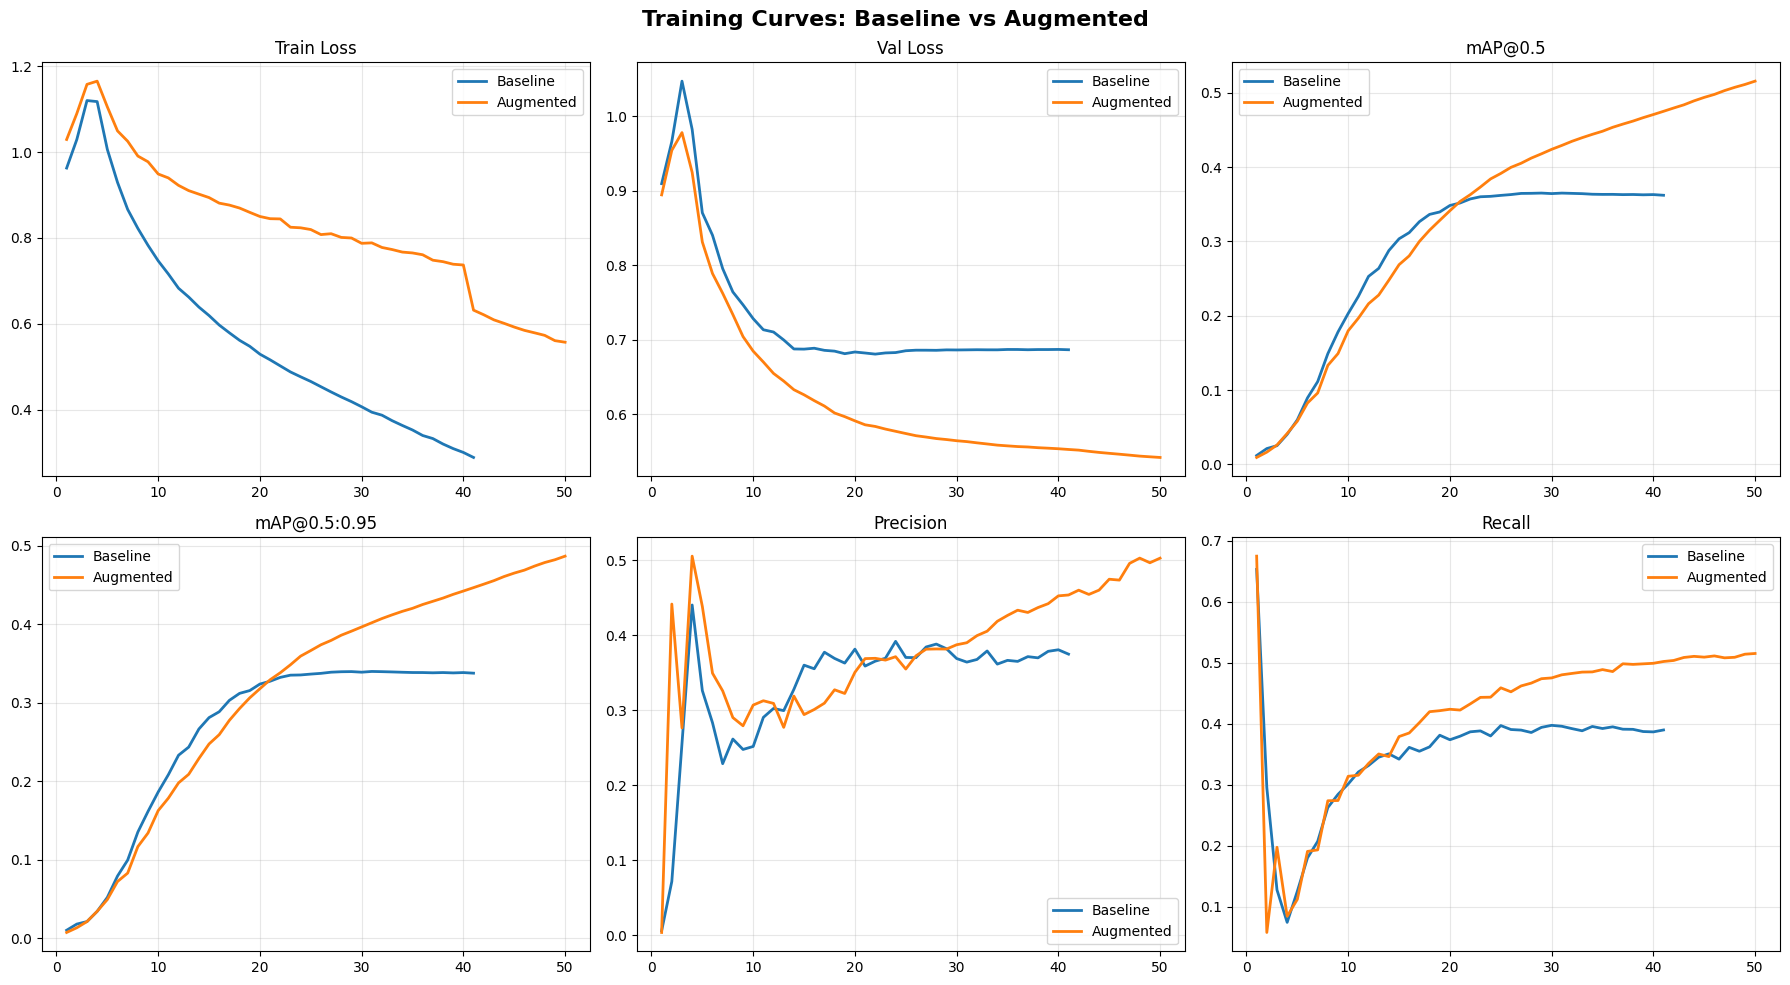

In [16]:
baseline_hist = pd.read_csv(RESULTS_DIR / 'baseline_no_aug5/results.csv')
augmented_hist = pd.read_csv(RESULTS_DIR / 'augmented_on_fly/results.csv')

baseline_hist.columns = baseline_hist.columns.str.strip()
augmented_hist.columns = augmented_hist.columns.str.strip()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training Curves: Baseline vs Augmented', fontsize=16, fontweight='bold')

axes[0,0].plot(baseline_hist['epoch'], baseline_hist['train/box_loss'], label='Baseline', lw=2)
axes[0,0].plot(augmented_hist['epoch'], augmented_hist['train/box_loss'], label='Augmented', lw=2)
axes[0,0].set_title('Train Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(baseline_hist['epoch'], baseline_hist['val/box_loss'], label='Baseline', lw=2)
axes[0,1].plot(augmented_hist['epoch'], augmented_hist['val/box_loss'], label='Augmented', lw=2)
axes[0,1].set_title('Val Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[0,2].plot(baseline_hist['epoch'], baseline_hist['metrics/mAP50(B)'], label='Baseline', lw=2)
axes[0,2].plot(augmented_hist['epoch'], augmented_hist['metrics/mAP50(B)'], label='Augmented', lw=2)
axes[0,2].set_title('mAP@0.5')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

axes[1,0].plot(baseline_hist['epoch'], baseline_hist['metrics/mAP50-95(B)'], label='Baseline', lw=2)
axes[1,0].plot(augmented_hist['epoch'], augmented_hist['metrics/mAP50-95(B)'], label='Augmented', lw=2)
axes[1,0].set_title('mAP@0.5:0.95')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(baseline_hist['epoch'], baseline_hist['metrics/precision(B)'], label='Baseline', lw=2)
axes[1,1].plot(augmented_hist['epoch'], augmented_hist['metrics/precision(B)'], label='Augmented', lw=2)
axes[1,1].set_title('Precision')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

axes[1,2].plot(baseline_hist['epoch'], baseline_hist['metrics/recall(B)'], label='Baseline', lw=2)
axes[1,2].plot(augmented_hist['epoch'], augmented_hist['metrics/recall(B)'], label='Augmented', lw=2)
axes[1,2].set_title('Recall')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'yolov8n_training_curves.png', dpi=300, bbox_inches='tight')
print(f'Saved to Drive: {VIZ_DIR}/yolov8n_training_curves.png')
plt.show()

## Step 11: Summary

In [17]:
print('='*70)
print('TRAINING COMPLETE')
print('='*70)

print('\nBASELINE:')
print(f'  mAP@0.5: {metrics_baseline.box.map50:.4f}')

print('\nAUGMENTED:')
print(f'  mAP@0.5: {metrics_augmented.box.map50:.4f}')

print('\nOUTPUTS SAVED TO GOOGLE DRIVE:')
print(f'  {DRIVE_PROJECT}/results/')
print('\nDownload this folder to your Mac and copy to GitHub repo!')
print('='*70)

TRAINING COMPLETE

BASELINE:
  mAP@0.5: 0.3638

AUGMENTED:
  mAP@0.5: 0.5151

OUTPUTS SAVED TO GOOGLE DRIVE:
  /content/drive/MyDrive/521_final_project/results/

Download this folder to your Mac and copy to GitHub repo!


## Step 12: Download Results (Optional)

In [18]:
# Optional: Zip and download results
# Uncomment if you want to download directly from Colab

!cd /content/drive/MyDrive/521_final_plroject && zip -r training_results.zip results/
from google.colab import files
files.download('/content/drive/MyDrive/521_final_plroject/training_results.zip')

  adding: results/ (stored 0%)
  adding: results/models_output/ (stored 0%)
  adding: results/visualizations/ (stored 0%)
  adding: results/visualizations/training/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>